# Cliff Walking

This gridworld example compares SARSA and Q-learning, highlighting the difference between on-policy (SARSA) and off-policy (Q-learning) methods. Consider the gridworld shown below.
- This is a standard undiscounted ($\gamma=1$), episodic task, with start and goal states, and the usual actions causing movement $up, down, right, left$.
- Reward is -1 on all transitions except those into the region marked “The Cliff.”
  - Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

In [1]:
from IPython.display import Image

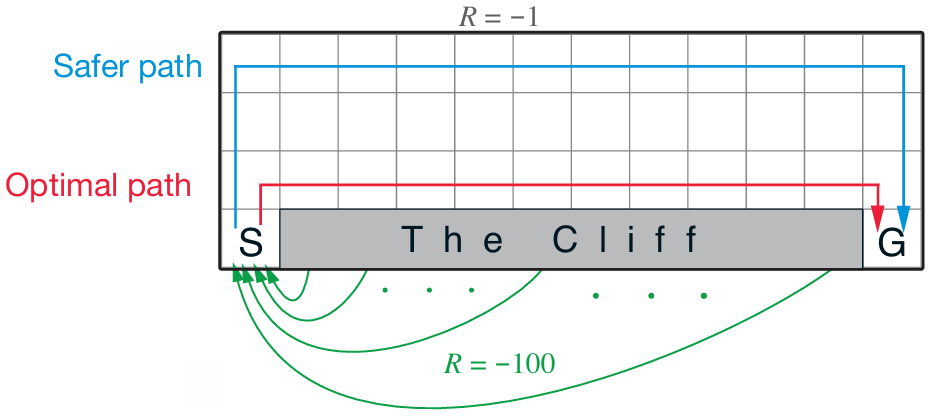

In [2]:
Image(filename="../book_images/Example_6_6_grid.PNG")

 The graph below shows the performance of the SARSA and Q-learning methods with $\varepsilon$-greedy action selection, $\varepsilon=0.1$. 
 - After an initial transient, Q-learning learns values for the optimal policy, that which travels right along the edge of the cliff. 
   - Unfortunately, this results in its occasionally falling off the cliff because of the $\varepsilon$-greedy action selection.
 - SARSA, on the other hand, takes the action selection into account and learns the longer but safer path through the upper part of the grid.
- Although Q-learning actually learns the values of the optimal policy, its online performance is worse than that of SARSA, which learns the roundabout policy.
- Of course, if $\varepsilon$ were gradually reduced, then both methods would asymptotically converge to the optimal policy.

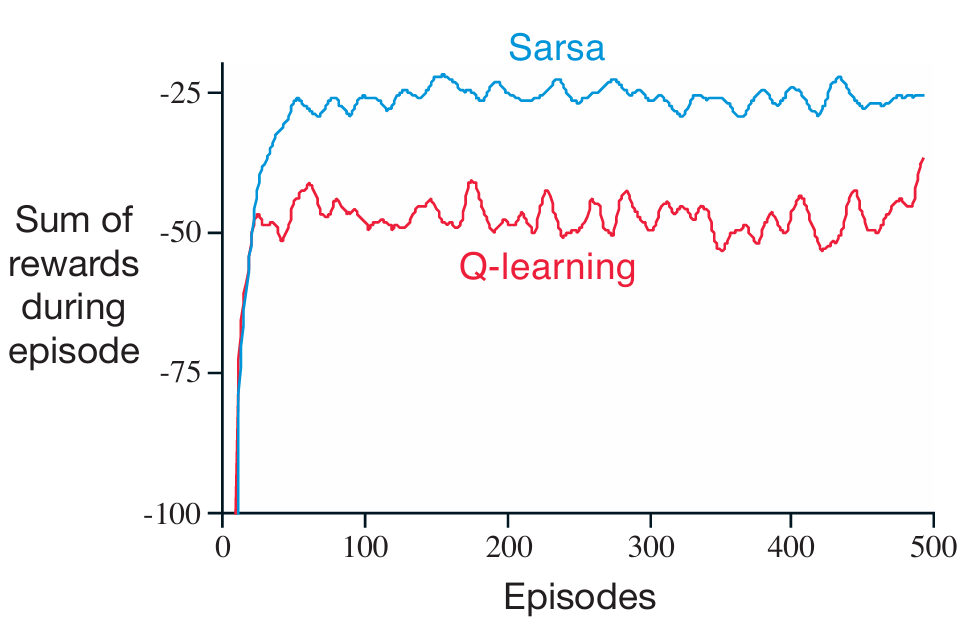

In [3]:
Image(filename="../book_images/Example_6_6_graph.PNG")

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

matplotlib.use('Agg')

In [5]:
from src.cliff_walking import world, sarsa, q_learning, print_optimal_policy

In [6]:
# Number of independent runs
runs = 50

# Number of episodes of each run
episodes = 500

In [7]:
# Create an array for SARSA rewards filled with 0s
rewards_sarsa = np.zeros(episodes)

# Create an array for Q-learning rewards filled with 0s
rewards_q_learning = np.zeros(episodes)

In [8]:
for _ in tqdm(range(runs)):
    # Create a matrix for SARSA action-value estimates filled with 0s
    sarsa_estimates = np.zeros((world["height"], world["width"], 4))
    
    # Create a matrix for Q-learning action-value estimates
    q_learning_estimates = np.copy(sarsa_estimates)
    
    for i in range(0, episodes):
        # Cut off the value by -100 to draw the figure more elegantly
        # rewards_sarsa[i] += max(sarsa(sarsa_estimates), -100)
        # rewards_q_learning[i] += max(q_learning(q_learning_estimates), -100)
        
        rewards_sarsa[i] += sarsa(sarsa_estimates)
        rewards_q_learning[i] += q_learning(q_learning_estimates)

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


In [9]:
# Averaging SARSA rewards over independent runs
rewards_sarsa /= runs

# Averaging Q-learning rewards over independent runs
rewards_q_learning /= runs

In [10]:
# Draw reward curves
plt.plot(rewards_sarsa, label="SARSA")
plt.plot(rewards_q_learning, label="Q-learning")
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.ylim([-100, 0])
plt.legend()

In [11]:
plt.savefig("../generated_images/example_6_6.png")
plt.close()

## Display the optimal policy

In [12]:
# SARSA converges to the safe path
print("SARSA Optimal Policy:")
print_optimal_policy(action_value_estimates=sarsa_estimates)

SARSA Optimal Policy:
['→', '←', '↓', '↓', '←', '→', '→', '→', '→', '→', '→', '↓']
['→', '→', '←', '→', '↓', '↓', '→', '→', '→', '→', '→', '↓']
['↑', '↑', '←', '←', '→', '→', '↑', '↑', '←', '↑', '→', '↓']
['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']


In [13]:
# Q-Learning converges to the optimal path
print("Q-learning Optimal Policy:")
print_optimal_policy(action_value_estimates=q_learning_estimates)

Q-learning Optimal Policy:
['↑', '→', '→', '→', '→', '→', '→', '→', '→', '↓', '↓', '↓']
['→', '→', '↓', '→', '→', '→', '→', '→', '↓', '→', '↓', '↓']
['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']
['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']


## Comparison

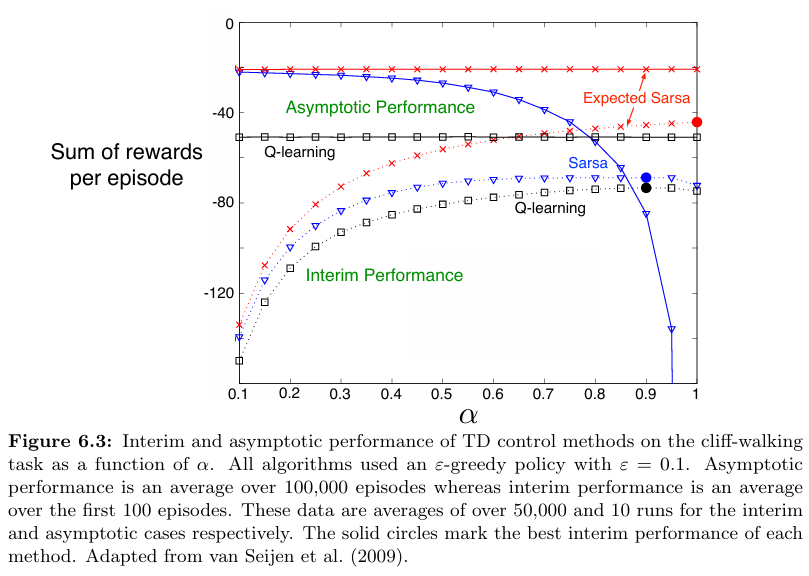

In [14]:
Image(filename="../book_images/Figure_6_3.PNG")

In [15]:
# Number of independent runs (to get the fully averaged performance set the number of runs to 50000)
runs = 10

# Number of episodes of each run (to get the fully averaged performance set the number of episodes to 100000)
episodes = 1000

In [16]:
# Methods to compare
methods = dict(asymptotic_sarsa = 0, asymptotic_expected_sarsa = 1, asymptotic_q_learning = 2, 
               interim_sarsa = 3, interim_expected_sarsa = 4, interim_q_learning = 5)

# List of step-size parameters
step_sizes = np.arange(0.1, 1.1, 0.1)

In [17]:
# Create a matrix for algorithm performance comparison
performance = np.zeros((len(methods), len(step_sizes)))

for run in range(runs):
    for index, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
        # Create a matrix for SARSA action-value estimates filled with 0s
        sarsa_estimates = np.zeros((world["height"], world["width"], 4))
        
        # Create a matrix for Expected SARSA action-value estimates
        expected_sarsa_estimates = np.copy(sarsa_estimates)
        
        # Create a matrix for Q-learning action-value estimates
        q_learning_estimates = np.copy(sarsa_estimates)
        
        for episode in range(episodes):
            # Get SARSA rewards
            sarsa_reward = sarsa(action_value_estimates=sarsa_estimates, expected=False, step_size=step_size)
            
            # Get Expected SARSA rewards
            expected_sarsa_reward = sarsa(action_value_estimates=expected_sarsa_estimates, expected=True, step_size=step_size)
            
            # Get Q-learning rewards
            q_learning_reward = q_learning(action_value_estimates=q_learning_estimates, step_size=step_size)
            
            # Add rewards for an asymptotic performance
            performance[methods["asymptotic_sarsa"], index] += sarsa_reward
            performance[methods["asymptotic_expected_sarsa"], index] += expected_sarsa_reward
            performance[methods["asymptotic_q_learning"], index] += q_learning_reward

            # Add rewards for an interim performance over the first 100 episodes
            if episode < 100:
                performance[methods["interim_sarsa"], index] += sarsa_reward
                performance[methods["interim_expected_sarsa"], index] += expected_sarsa_reward
                performance[methods["interim_q_learning"], index] += q_learning_reward

100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


In [18]:
# Asymptotic performance is an average over all episodes
performance[:3, :] /= episodes * runs

# Interim performance is an average over the first 100 episodes
performance[3:, :] /= 100 * runs

labels = ["Asymptotic SARSA", "Asymptotic Expected SARSA", "Asymptotic Q-learning",
          "Interim SARSA", "Interim Expected SARSA", "Interim Q-learning"]

In [19]:
# Plotting
for method, label in zip(methods.values(), labels):
    plt.plot(step_sizes, performance[method, :], label=label)

plt.xlabel(r"Step-size parameter ($\alpha$)")
plt.ylabel("Sum of rewards per episode")
plt.legend()

In [20]:
plt.savefig("../generated_images/figure_6_3.png")
plt.close()